In [2]:
import numpy as np
from scipy.stats import multivariate_normal

class GaussianHMM:
    def __init__(self, n_states, n_features, epsilon=1e-6):
        self.n_states = n_states
        self.n_features = n_features
        self.epsilon = epsilon
        self.means = np.random.rand(n_states, n_features)
        self.covs = np.array([np.eye(n_features) for _ in range(n_states)])
        self.trans_probs = np.full((n_states, n_states), 1/n_states) + epsilon
        self.init_probs = np.full(n_states, 1/n_states) + epsilon

    def _forward(self, obs):
        alpha = np.full((len(obs), self.n_states), -np.inf)
        for i in range(self.n_states):
            alpha[0, i] = np.log(self.init_probs[i]) + multivariate_normal.logpdf(obs[0], mean=self.means[i], cov=self.covs[i])
        
        for t in range(1, len(obs)):
            for j in range(self.n_states):
                alpha[t, j] = multivariate_normal.logpdf(obs[t], mean=self.means[j], cov=self.covs[j]) + np.logaddexp.reduce(alpha[t-1] + np.log(self.trans_probs[:, j] + self.epsilon))
                
        return alpha

    def _backward(self, obs):
        beta = np.full((len(obs), self.n_states), -np.inf)
        beta[-1] = np.log(1)
        
        for t in range(len(obs) - 2, -1, -1):
            for j in range(self.n_states):
                beta[t, j] = np.logaddexp.reduce(beta[t+1] + multivariate_normal.logpdf(obs[t+1], mean=self.means[j], cov=self.covs[j]) + np.log(self.trans_probs[j] + self.epsilon))
                
        return beta

    def _em_step(self, obs, alpha, beta):
        gamma = alpha + beta - np.logaddexp.reduce(alpha[-1] + self.epsilon)
        xi = np.zeros((len(obs)-1, self.n_states, self.n_states))
        
        for t in range(len(obs)-1):
            for i in range(self.n_states):
                for j in range(self.n_states):
                    xi[t, i, j] = alpha[t, i] + np.log(self.trans_probs[i, j] + self.epsilon) + multivariate_normal.logpdf(obs[t+1], mean=self.means[j], cov=self.covs[j]) + beta[t+1, j] - np.logaddexp.reduce(alpha[-1] + self.epsilon)
    
        return gamma, xi

    def fit(self, obs, n_iter=10):
        for _ in range(n_iter):
            alpha = self._forward(obs)
            beta = self._backward(obs)
            gamma, xi = self._em_step(obs, alpha, beta)
            
            self.init_probs = np.exp(gamma[0]) + self.epsilon
            self.trans_probs = np.exp(xi.sum(axis=0)) / np.exp(gamma[:-1]).sum(axis=0)[:, np.newaxis] + self.epsilon

            for i in range(self.n_states):
                weight = np.exp(gamma[:, i])
                self.means[i] = np.dot(weight, obs) / np.sum(weight)
                diff = obs - self.means[i]
                self.covs[i] = np.dot(weight * diff.T, diff) / np.sum(weight) + self.epsilon * np.eye(self.n_features)

    def predict(self, obs):
        alpha = self._forward(obs)
        return np.argmax(alpha, axis=1)


The code implements a Gaussian Hidden Markov Model (HMM) using the expectation-maximization (EM) algorithm for parameter estimation.

**Mathematical Model**

The Gaussian HMM is defined by the following parameters:
- $N$: Number of states in the HMM.
- $M$: Number of features in each observation.
- $T$: Length of the observation sequence.
- $O = \{o_1, o_2, ..., o_T\}$: Observation sequence.

The model parameters include:
- Initial State Probabilities: $\boldsymbol{\pi} = \{\pi_i\}$, where $\pi_i$ is the probability of starting in state $i$.
- Transition Probabilities: $\mathbf{A} = \{a_{ij}\}$, where $a_{ij}$ is the probability of transitioning from state $i$ to state $j$.
- Gaussian Distributions: Mean Vectors $\boldsymbol{\mu} = \{\boldsymbol{\mu}_i\}$ and Covariance Matrices $\boldsymbol{\Sigma} = \{\boldsymbol{\Sigma}_i\}$, representing the means and covariances of the Gaussian distributions for each state.

**Algorithm**

The Gaussian HMM algorithm consists of the following steps:

1. **Forward Algorithm**:
   - The `_forward` method computes the forward probabilities (alpha) for the given observations using the current model parameters. It uses the logarithm of probabilities to avoid numerical underflow.
   - Initialization: $\alpha_1(i) = \log(\pi_i) + \log(\mathcal{N}(o_1|\boldsymbol{\mu}_i, \boldsymbol{\Sigma}_i))$, for $i = 1, 2, ..., N$, where $\mathcal{N}(x|\boldsymbol{\mu}, \boldsymbol{\Sigma})$ is the multivariate Gaussian probability density function.
   - Recursion: $\alpha_t(j) = \log(\mathcal{N}(o_t|\boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)) + \log\left(\sum_{i=1}^{N} \exp(\alpha_{t-1}(i) + \log(a_{ij}))\right)$, for $t = 2, 3, ..., T$ and $j = 1, 2, ..., N$.

2. **Backward Algorithm**:
   - The `_backward` method computes the backward probabilities (beta) for the given observations using the current model parameters. Similar to `_forward`, it uses the logarithm of probabilities.
   - Initialization: $\beta_T(i) = \log(1)$, for $i = 1, 2, ..., N$.
   - Recursion: $\beta_t(i) = \log\left(\sum_{j=1}^{N} \exp(\beta_{t+1}(j) + \log(a_{ij}) + \log(\mathcal{N}(o_{t+1}|\boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)))\right)$, for $t = T-1, T-2, ..., 1$ and $i = 1, 2, ..., N$.

3. **Expectation-Maximization (EM) Step**:
   - The `_em_step` method performs one EM step of the algorithm. It computes the gamma and xi variables, which are used to update the model parameters.
   - Gamma Computation: $\gamma_t(i) = \alpha_t(i) + \beta_t(i) - \log\left(\sum_{j=1}^{N} \exp(\alpha_T(j))\right)$, for $t = 1, 2, ..., T$ and $i = 1, 2, ..., N$.
   - Xi Computation: $\xi_t(i,j) = \alpha_t(i) + \log(a_{ij}) + \log(\mathcal{N}(o_{t+1}|\boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)) + \beta_{t+1}(j) - \log\left(\sum_{k=1}^{N} \sum_{l=1}^{N} \exp(\alpha_T(l))\right)$, for $t = 1, 2, ..., T-1$ and $i,j = 1, 2, ..., N$.

4. **EM Algorithm**:
   - The `fit` method fits the model to the observations using the EM algorithm. It iteratively computes the forward and backward probabilities, performs the EM step, and updates the model parameters.
   - Update Initial State Probabilities: $\pi_i = \exp(\gamma_1(i))$, for $i = 1, 2, ..., N$.
   - Update Transition Probabilities: $a_{ij} = \frac{\exp(\sum_{t=1}^{T-1} \xi_t(i,j))}{\sum_{t=1}^{T-1} \exp(\gamma_t(i))}$, for $i,j = 1, 2, ..., N$.
   - Update Means: $\boldsymbol{\mu}_i = \frac{\sum_{t=1}^{T} \exp(\gamma_t(i)) \cdot o_t}{\sum_{t=1}^{T} \exp(\gamma_t(i))}$, for $i = 1, 2, ..., N$.
   - Update Covariance Matrices: $\boldsymbol{\Sigma}_i = \frac{\sum_{t=1}^{T} \exp(\gamma_t(i)) \cdot (o_t - \boldsymbol{\mu}_i)(o_t - \boldsymbol{\mu}_i)^\top}{\sum_{t=1}^{T} \exp(\gamma_t(i))}$, for $i = 1, 2, ..., N$.

**Usage**

To use this code:
1. Create an instance of the `GaussianHMM` class, providing the number of states and features.
2. Call the `fit` method, passing the observation sequence to train the model.
3. Call the `predict` method with new observations to obtain the predicted state sequence.


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm

# Fetching the data
data = yf.download('MGM', start='2019-01-01', end='2023-12-31')

# Calculating log returns
data['Log Returns'] = np.log(data['Close'] / data['Close'].shift(1))

# Calculating the volatility
data['Volatility'] = data['Log Returns'].rolling(window=21).std() * np.sqrt(252)

# Removing NA
data.dropna(inplace=True)

# Preparing the data for the HMM
obs = np.column_stack([data['Log Returns'], data['Volatility']])


[*********************100%***********************]  1 of 1 completed


In [4]:
# Defining the number of states
n_states = 3
n_features = obs.shape[1]

# Create an instance of the HMM class
hmm = GaussianHMM(n_states, n_features)

# Fit the model to the data
hmm.fit(obs)

# Predict the hidden states
states = hmm.predict(obs)


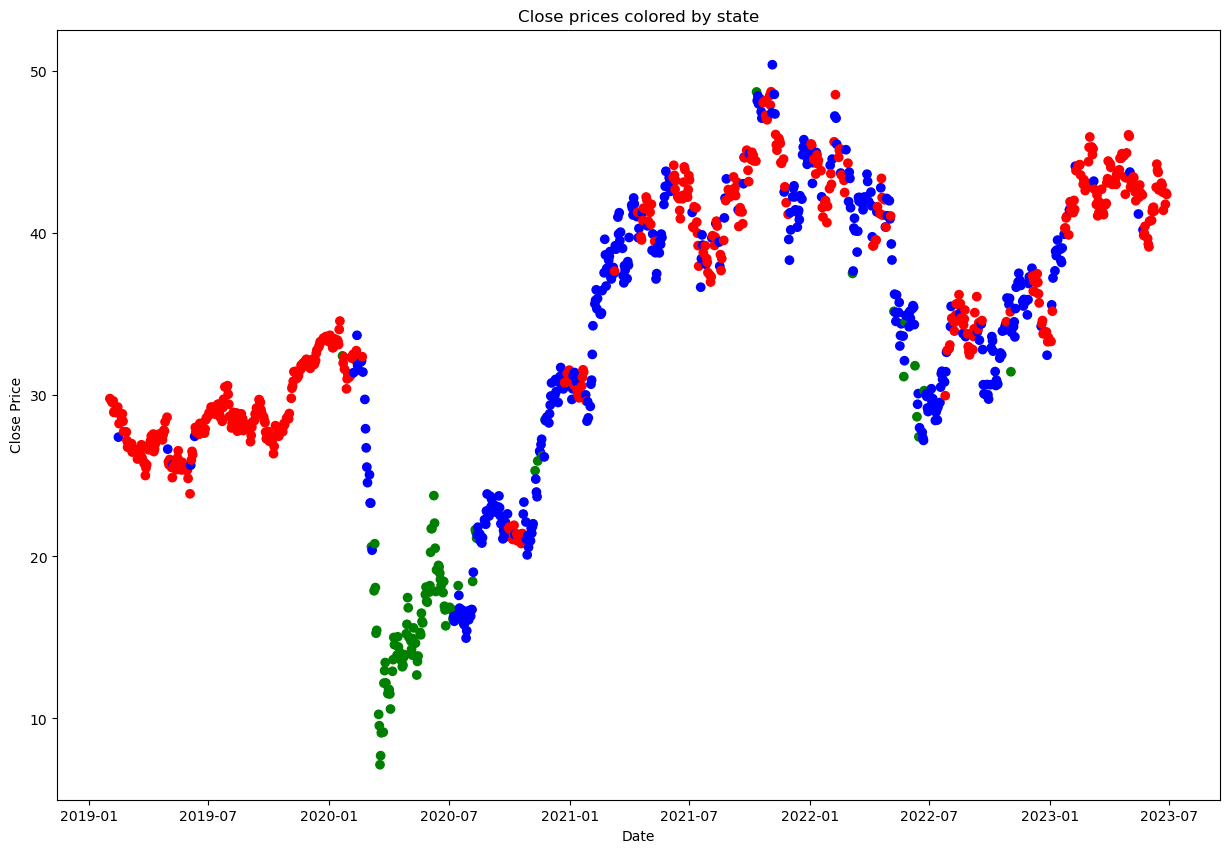

In [5]:
import matplotlib.pyplot as plt

# We'll define states 0, 1, 2 as "Bear", "Sideways", "Bull" respectively
state_colors = ["red", "green", "blue"]

# Creating a new column for the states
data['States'] = states
data['State_Color'] = data['States'].apply(lambda x: state_colors[x])

# Plotting the time series colored by state
plt.figure(figsize=(15, 10))
plt.scatter(data.index, data['Close'], c=data['State_Color'])
plt.title('Close prices colored by state')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


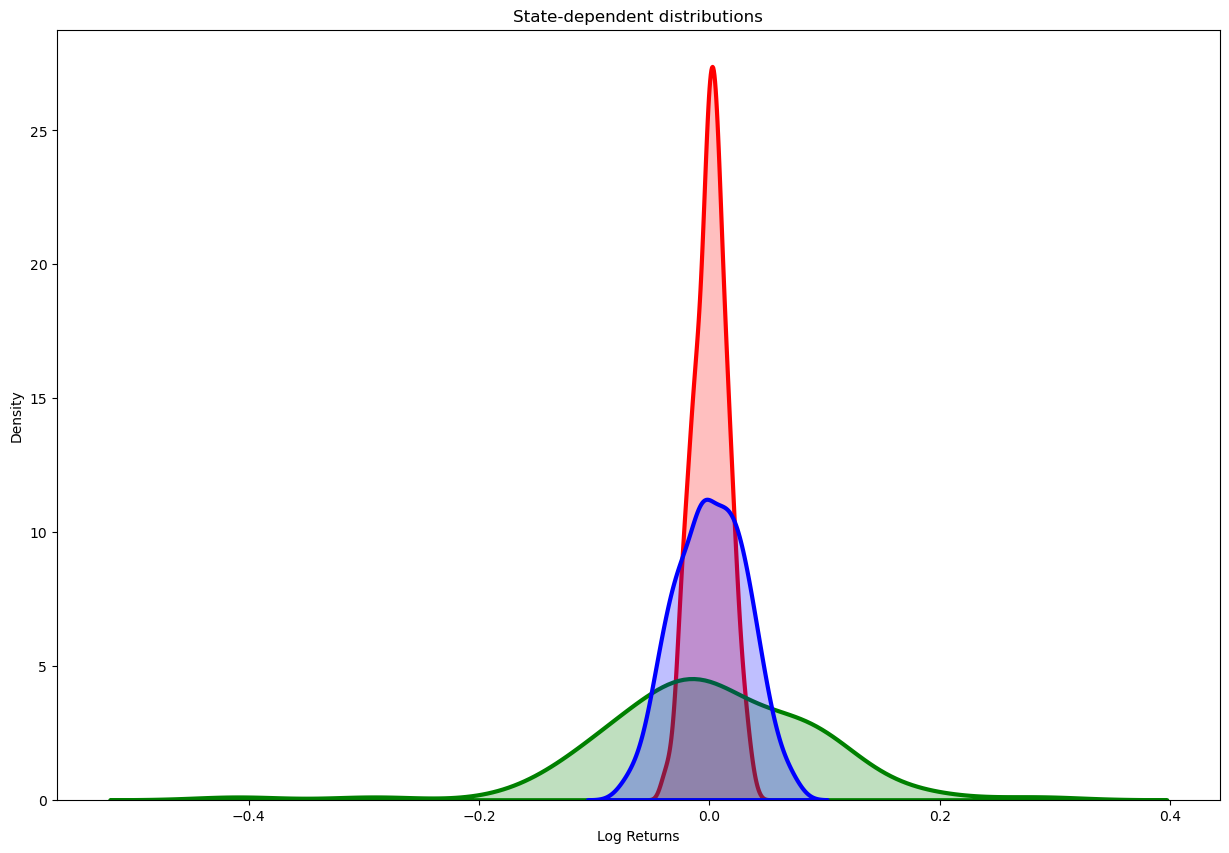

In [10]:
import seaborn as sns

# Plotting the state-dependent distributions
plt.figure(figsize=(15, 10))
for i, color in enumerate(state_colors):
    sns.kdeplot(data[data['States'] == i]['Log Returns'], fill = True, 
                color = color, label = f'State {i}', linewidth=3)
plt.title('State-dependent distributions')
plt.xlabel('Log Returns')
plt.show()


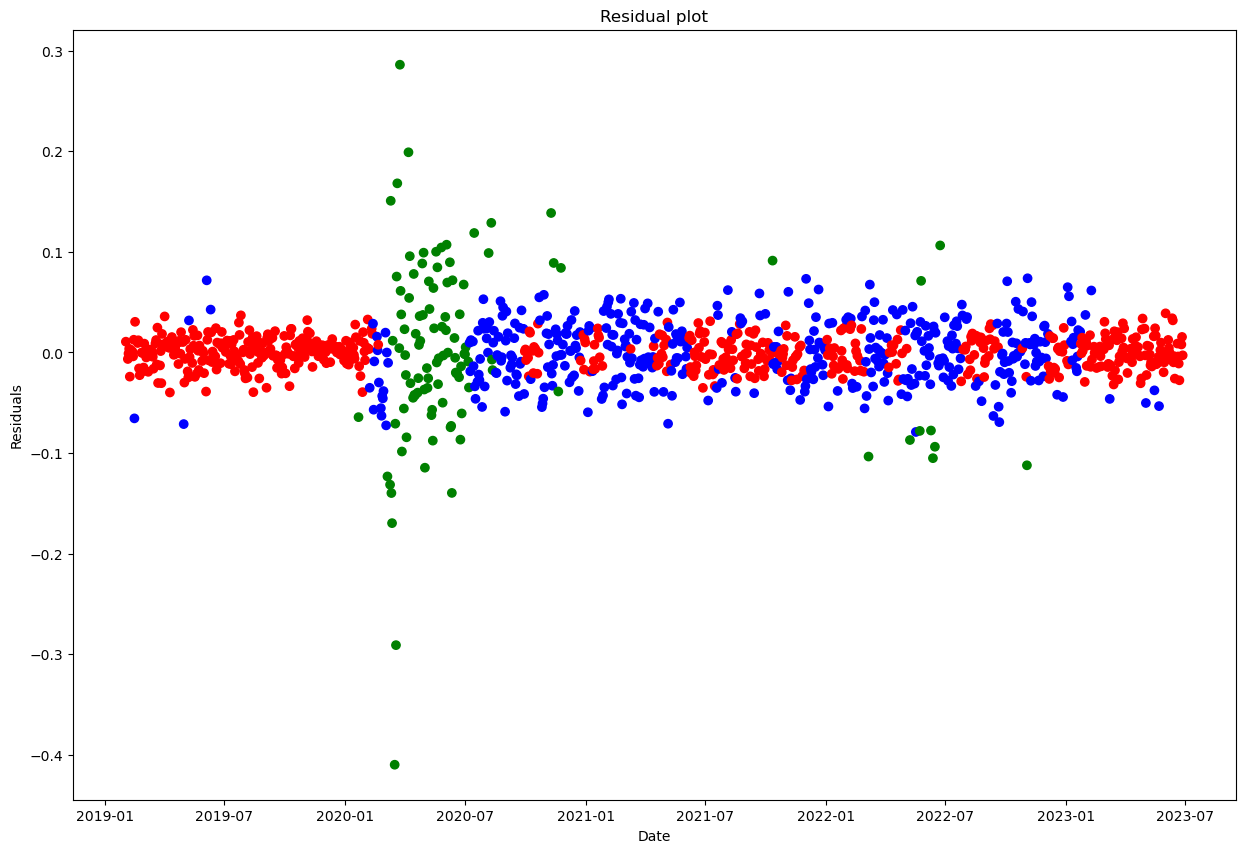

In [7]:
from sklearn.linear_model import LinearRegression

# Calculating the residuals
model = LinearRegression()
model.fit(np.arange(len(data)).reshape(-1, 1), data['Log Returns'].values.reshape(-1, 1))
predicted = model.predict(np.arange(len(data)).reshape(-1, 1))
residuals = data['Log Returns'].values.reshape(-1, 1) - predicted

# Plotting the residuals
plt.figure(figsize=(15, 10))
plt.scatter(data.index, residuals, c=data['State_Color'])
plt.title('Residual plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()


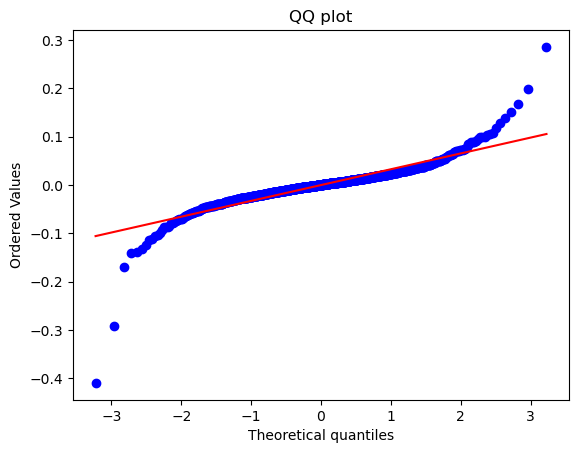

In [8]:
import scipy.stats as stats

# Generating the QQ plot
stats.probplot(residuals.flatten(), dist="norm", plot=plt)
plt.title('QQ plot')
plt.show()


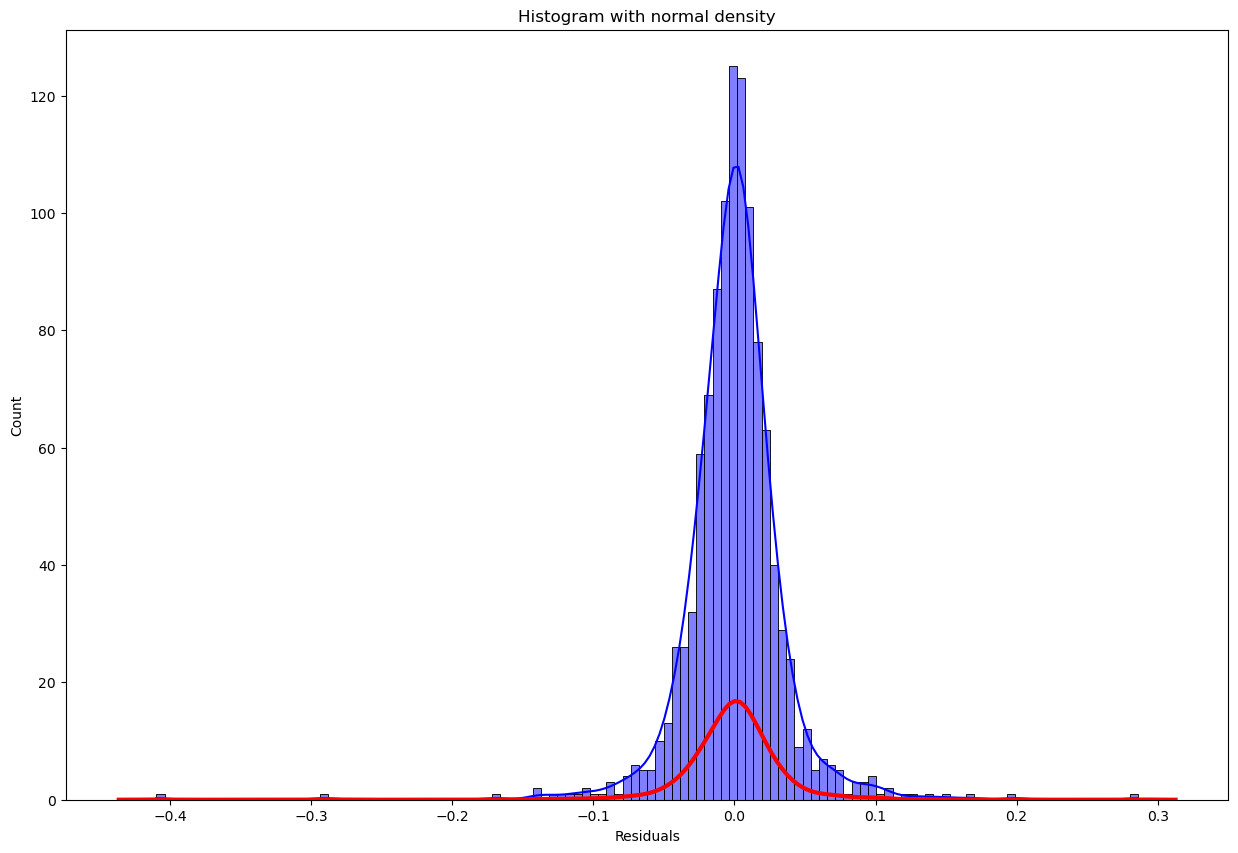

In [11]:
# Plotting the histogram with normal density
plt.figure(figsize=(15, 10))
sns.histplot(data=residuals.flatten(), kde = True, color = 'blue')
sns.kdeplot(data=residuals.flatten(), color = 'red', linewidth=3)
plt.title('Histogram with normal density')
plt.xlabel('Residuals')
plt.show()
